In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd

%matplotlib inline

sess = tf.InteractiveSession()
init = tf.global_variables_initializer()

In [2]:
with np.load("notMNIST.npz") as data :
    Data, Target = data ["images"], data["labels"]
    posClass = 2
    negClass = 9
    dataIndx = (Target==posClass) + (Target==negClass)
    Data = Data[dataIndx]/255.
    Target = Target[dataIndx].reshape(-1, 1)
    Target[Target==posClass] = 1
    Target[Target==negClass] = 0
    np.random.seed(521)
    randIndx = np.arange(len(Data))
    np.random.shuffle(randIndx)
    Data, Target = Data[randIndx], Target[randIndx]
    trainData, trainTarget = np.reshape(Data[:3500], (3500, 784)), Target[:3500]
    validData, validTarget = np.reshape(Data[3500:3600], (100, 784)), Target[3500:3600]
    testData, testTarget = np.reshape(Data[3600:], (145, 784)), Target[3600:]

In [3]:
# container class for model results
class ModelResult():
    def __init__(self):
        self.loss_profile = None
        
        self.train_loss = None
        self.valid_loss = None
        self.test_loss = None
        
        self.train_y_hat = None
        self.valid_y_hat = None
        self.test_y_hat = None     

## Binary Cross-Entropy Loss

Train a tensorflow model on the two-class notMNIST dataset.

In [4]:
def logistic_regression_model(batch_size, λ, η, optimizer_type='adam'):
    # constants
    MAX_NUM_EPOCHS = 1000
    
    # return parameters
    num_gradient_descent_steps = 0
    loss_profile = []

    # tf varibales - weights and bias
    W = tf.Variable(tf.zeros([784, 1]))
    b = tf.Variable(0.)

    # data/target placeholders for each iteration
    x = tf.placeholder(tf.float32, name='x')
    y = tf.placeholder(tf.float32, name='y')

    # y_hat output prediction function
    y_hat = tf.sigmoid(tf.matmul(x, W) + b)

    # mean squared loss with weight decay
    cross_entropy_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(tf.matmul(x, W) + b, y)) \
                                + (λ / 2) * tf.reduce_sum(tf.square(W))

    # gradient descent optimizer
    optimizer = None
    if optimizer_type == 'standard':
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=η)
    elif optimizer_type == 'adam':
        optimizer = tf.train.AdamOptimizer(learning_rate=η)
    train = optimizer.minimize(loss=cross_entropy_loss)

    # variable initialization
    init = tf.global_variables_initializer()
    sess.run(init)
    sess.run([W, b])
    
    # init batch selection indices
    batch_selection_indices = np.linspace(0, trainData.shape[0] - 1, trainData.shape[0], dtype=np.int32)
    
    # MAX_NUM_EPOCHS represents exit condition 1
    done = False
    prev_loss = float('inf')
    while not done:
        # initialize batch selection variables
        np.random.seed(num_gradient_descent_steps)
        np.random.shuffle(batch_selection_indices)
        batch_start = 0
        batch_end = batch_size
        batching_complete = False
        
        while not batching_complete:
            # obtain current batch
            batch_data = trainData[batch_selection_indices[batch_start:batch_end]]
            batch_target = trainTarget[batch_selection_indices[batch_start:batch_end]]
            
            # prepare for next batch
            batch_start += batch_size
            batch_end += batch_size
            batching_complete = batch_start == trainData.shape[0]
            
            # perform train step
            train_res, loss, curr_W, curr_b = sess.run([train, cross_entropy_loss, W, b], \
                                                       feed_dict={x:batch_data, y:batch_target})

            # check overall loss after gradient descent step
            overall_loss = sess.run(cross_entropy_loss, feed_dict={x:trainData, y:trainTarget})
            loss_profile.append(overall_loss)
            
            # exit condition
            if num_gradient_descent_steps == MAX_NUM_EPOCHS:
                done = True
                break
            num_gradient_descent_steps += 1
            
                
    # write results
    model_result = ModelResult()
    
    # loss profile
    model_result.loss_profile = loss_profile
    
    # obtain losses
    model_result.train_loss = sess.run(cross_entropy_loss, feed_dict={x:trainData, y:trainTarget})
    model_result.valid_loss = sess.run(cross_entropy_loss, feed_dict={x:validData, y:validTarget})
    model_result.test_loss = sess.run(cross_entropy_loss, feed_dict={x:testData, y:testTarget})
    
    # obtain resulting y_hat
    model_result.train_y_hat = sess.run(y_hat, feed_dict={x:trainData})
    model_result.valid_y_hat = sess.run(y_hat, feed_dict={x:validData})
    model_result.test_y_hat = sess.run(y_hat, feed_dict={x:testData})
    
    return model_result

### Train the Model Using the Standard Optimizer

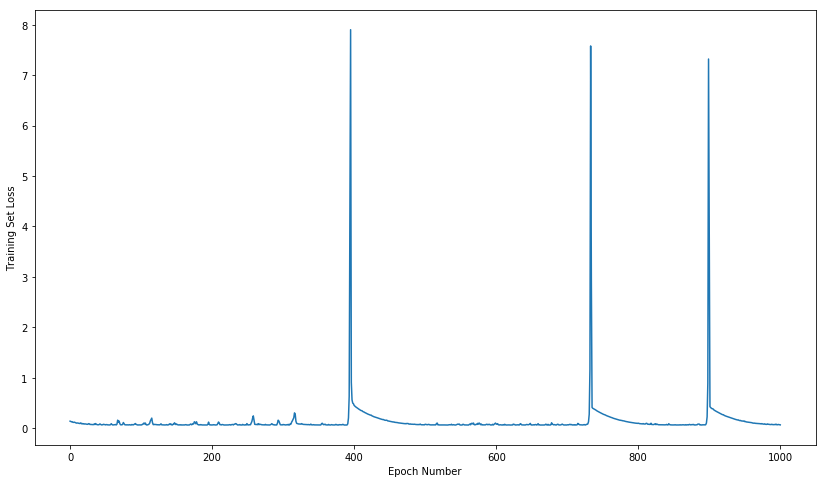

In [5]:
model_result = logistic_regression_model(batch_size=500, λ=0.01, η=1, \
                                                  optimizer_type='standard')

plt.figure(figsize=(14, 8))
plt.plot(list(range(len(model_result.loss_profile))), model_result.loss_profile)
plt.xlabel('Epoch Number')
plt.ylabel('Training Set Loss')
plt.savefig('1.1.1-divergence.png')

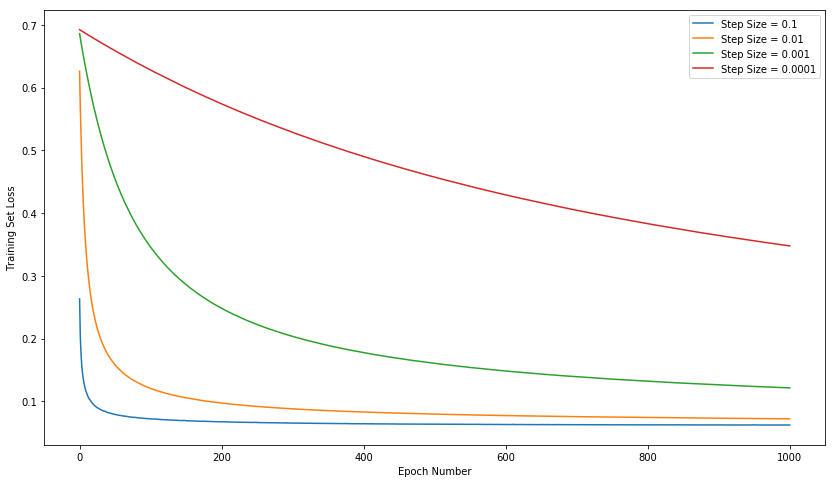

In [21]:
η_values = [.1, 0.01, 0.001, 0.0001]
convergence_speed = []

plt.figure(figsize=(14, 8))

# obtain convergence speed per η value
for η in η_values:
    model_result = logistic_regression_model(batch_size=500, λ=0.01, η=η, \
                                                      optimizer_type='standard')
    
    plt.plot(list(range(len(model_result.loss_profile))), model_result.loss_profile, \
             label='Step Size = '+str(η))
    

plt.legend()
plt.ylabel('Training Set Loss')
plt.xlabel('Epoch Number')
plt.savefig('1.1.1-convergence.png')

### Train the Model Using the Adam Optimizer

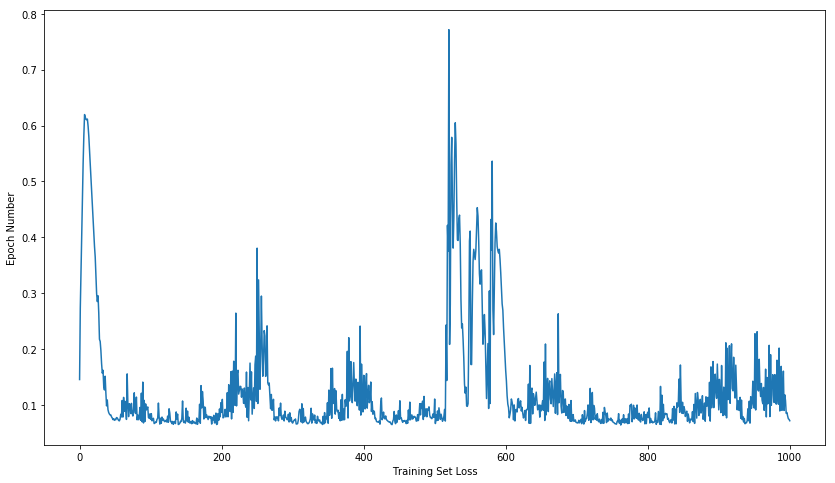

In [20]:
model_result = logistic_regression_model(batch_size=500, λ=0.01, η=0.1, \
                                                  optimizer_type='adam')

plt.figure(figsize=(14, 8))
plt.plot(list(range(len(model_result.loss_profile))), model_result.loss_profile)
plt.ylabel('Epoch Number')
plt.xlabel('Training Set Loss')
plt.savefig('1.1.2-divergence.png')

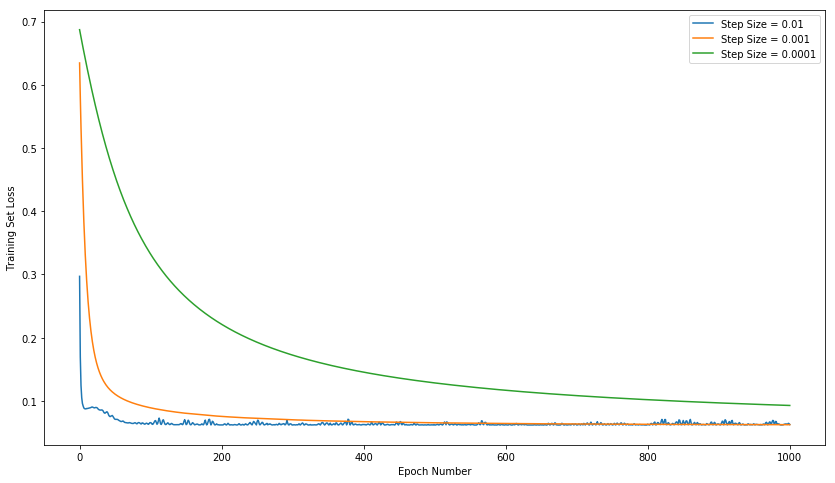

In [22]:
η_values = [0.01, 0.001, .0001]
convergence_speed = []

plt.figure(figsize=(14, 8))

# obtain convergence speed per η value
for η in η_values:
    model_result = logistic_regression_model(batch_size=500, λ=0.01, η=η, \
                                                      optimizer_type='adam')
    
    plt.plot(list(range(len(model_result.loss_profile))), model_result.loss_profile, \
             label='Step Size = '+str(η))
    

plt.legend()
plt.ylabel('Training Set Loss')
plt.xlabel('Epoch Number')
plt.savefig('1.1.2-convergence.png')

### Comparison With Linear SGD

In [9]:
def linear_regression_model(batch_size, λ, η, optimizer_type='adam'):
    # constants
    MAX_NUM_EPOCHS = 1000
    
    # return parameters
    num_gradient_descent_steps = 0
    loss_profile = []

    # tf varibales - weights and bias
    W = tf.Variable(tf.zeros([784, 1]))
    b = tf.Variable(0.)

    # data/target placeholders for each iteration
    x = tf.placeholder(tf.float32, name='x')
    y = tf.placeholder(tf.float32, name='y')

    # y_hat output prediction function
    y_hat = tf.matmul(x, W) + b

    # mean squared loss with weight decay
    mse_weight_decay = 0.5 * tf.reduce_mean(tf.reduce_sum(tf.square(y_hat - y), reduction_indices=1)) \
                                + (λ / 2) * tf.reduce_sum(tf.square(W))

    # gradient descent optimizer
    optimizer = None
    if optimizer_type == 'standard':
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=η)
    elif optimizer_type == 'adam':
        optimizer = tf.train.AdamOptimizer(learning_rate=η)
    train = optimizer.minimize(loss=mse_weight_decay)

    # variable initialization
    init = tf.global_variables_initializer()
    sess.run(init)
    sess.run([W, b])
    
    # init batch selection indices
    batch_selection_indices = np.linspace(0, trainData.shape[0] - 1, trainData.shape[0], dtype=np.int32)
    
    # MAX_NUM_EPOCHS represents exit condition 1
    done = False
    prev_loss = float('inf')
    while not done:
        # initialize batch selection variables
        np.random.seed(num_gradient_descent_steps)
        np.random.shuffle(batch_selection_indices)
        batch_start = 0
        batch_end = batch_size
        batching_complete = False
        
        while not batching_complete:
            # obtain current batch
            batch_data = trainData[batch_selection_indices[batch_start:batch_end]]
            batch_target = trainTarget[batch_selection_indices[batch_start:batch_end]]
            
            # prepare for next batch
            batch_start += batch_size
            batch_end += batch_size
            batching_complete = batch_start == trainData.shape[0]
            
            # perform train step
            train_res, loss, curr_W, curr_b = sess.run([train, mse_weight_decay, W, b], \
                                                       feed_dict={x:batch_data, y:batch_target})

            # check overall loss after gradient descent step
            overall_loss = sess.run(mse_weight_decay, feed_dict={x:trainData, y:trainTarget})
            loss_profile.append(overall_loss)
            
            # exit condition
            if num_gradient_descent_steps == MAX_NUM_EPOCHS:
                done = True
                break
            num_gradient_descent_steps += 1
            
                
    # write results
    model_result = ModelResult()
    
    # loss profile
    model_result.loss_profile = loss_profile
    
    # obtain losses
    model_result.train_loss = sess.run(mse_weight_decay, feed_dict={x:trainData, y:trainTarget})
    model_result.valid_loss = sess.run(mse_weight_decay, feed_dict={x:validData, y:validTarget})
    model_result.test_loss = sess.run(mse_weight_decay, feed_dict={x:testData, y:testTarget})
    
    # obtain resulting y_hat
    model_result.train_y_hat = sess.run(y_hat, feed_dict={x:trainData})
    model_result.valid_y_hat = sess.run(y_hat, feed_dict={x:validData})
    model_result.test_y_hat = sess.run(y_hat, feed_dict={x:testData})
    
    return model_result

### Train the Linear Model Using the Standard Optimizer

Final Training Set Loss: 0.0125701
Final Validation Set Loss: 0.0144666
Final Test Set Loss: 0.0185837
Final Training Set Prediction Performance: 3433 / 3500 - 98.0857142857 %
Final Validation Set Prediction Performance: 99 / 100 - 99.0 %
Final Test Set Prediction Performance: 140 / 145 - 96.5517241379 %


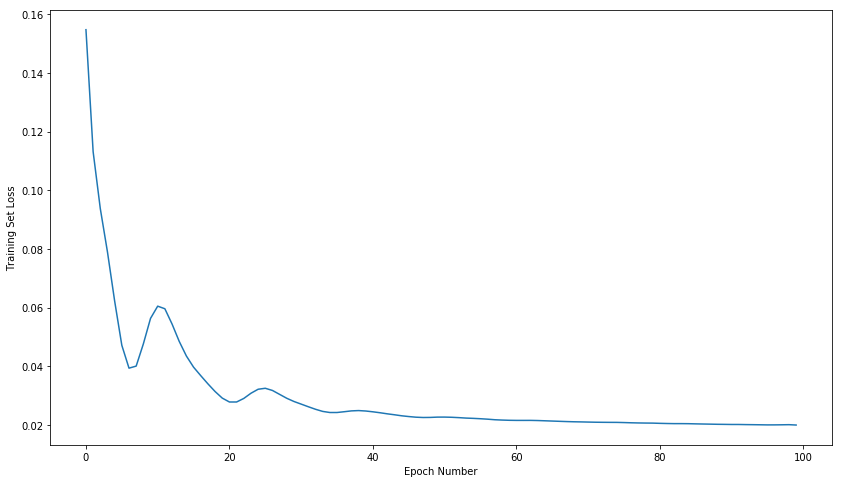

In [10]:
model_result = linear_regression_model(batch_size=500, λ=0, η=0.001)

plt.figure(figsize=(14, 8))
plt.plot(list(range(100)), model_result.loss_profile[:100])
plt.xlabel('Epoch Number')
plt.ylabel('Training Set Loss')
plt.savefig('1.1.3-linear.png')

print('Final Training Set Loss:', model_result.train_loss)
print('Final Validation Set Loss:', model_result.valid_loss)
print('Final Test Set Loss:', model_result.test_loss)

pred_train = np.sum(np.rint(model_result.train_y_hat) == trainTarget)
pred_valid = np.sum(np.rint(model_result.valid_y_hat) == validTarget)
pred_test = np.sum(np.rint(model_result.test_y_hat) == testTarget)

print('Final Training Set Prediction Performance:', pred_train, '/', trainData.shape[0], \
      '-', (pred_train/trainData.shape[0])*100, '%')
print('Final Validation Set Prediction Performance:', pred_valid, '/', validData.shape[0], \
      '-', (pred_valid/validData.shape[0])*100, '%')
print('Final Test Set Prediction Performance:', pred_test, '/', testData.shape[0], \
      '-', (pred_test/testData.shape[0])*100, '%')

### Train the Linear Model Using the Adam Optimizer

Final Training Set Loss: 0.0143117
Final Validation Set Loss: 0.0228795
Final Test Set Loss: 0.13531
Final Training Set Prediction Performance: 3487 / 3500 - 99.6285714286 %
Final Validation Set Prediction Performance: 99 / 100 - 99.0 %
Final Test Set Prediction Performance: 142 / 145 - 97.9310344828 %


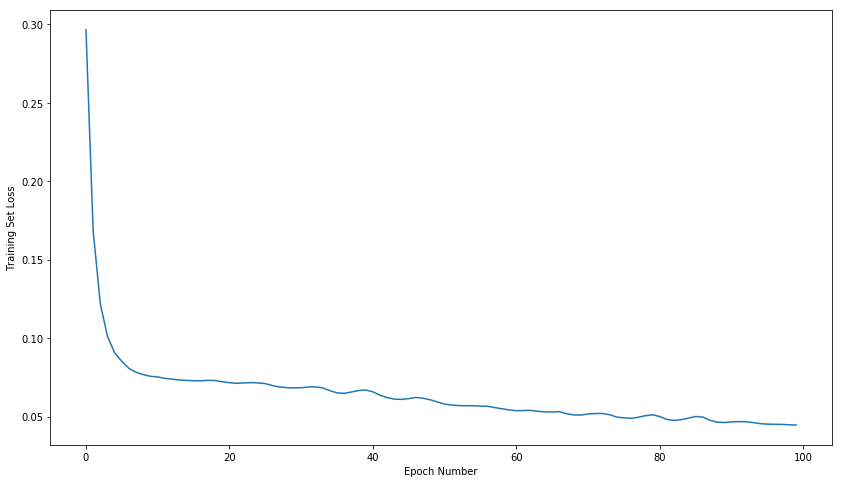

In [11]:
model_result = logistic_regression_model(batch_size=500, λ=0, η=0.01)

plt.figure(figsize=(14, 8))
plt.plot(list(range(100)), model_result.loss_profile[:100])
plt.xlabel('Epoch Number')
plt.ylabel('Training Set Loss')
plt.savefig('1.1.3-logistic.png')

print('Final Training Set Loss:', model_result.train_loss)
print('Final Validation Set Loss:', model_result.valid_loss)
print('Final Test Set Loss:', model_result.test_loss)

pred_train = np.sum(np.rint(model_result.train_y_hat) == trainTarget)
pred_valid = np.sum(np.rint(model_result.valid_y_hat) == validTarget)
pred_test = np.sum(np.rint(model_result.test_y_hat) == testTarget)

print('Final Training Set Prediction Performance:', pred_train, '/', trainData.shape[0], \
      '-', (pred_train/trainData.shape[0])*100, '%')
print('Final Validation Set Prediction Performance:', pred_valid, '/', validData.shape[0], \
      '-', (pred_valid/validData.shape[0])*100, '%')
print('Final Test Set Prediction Performance:', pred_test, '/', testData.shape[0], \
      '-', (pred_test/testData.shape[0])*100, '%')

### Comparison of Mean-Squared Error vs. Cross Entropy Loss

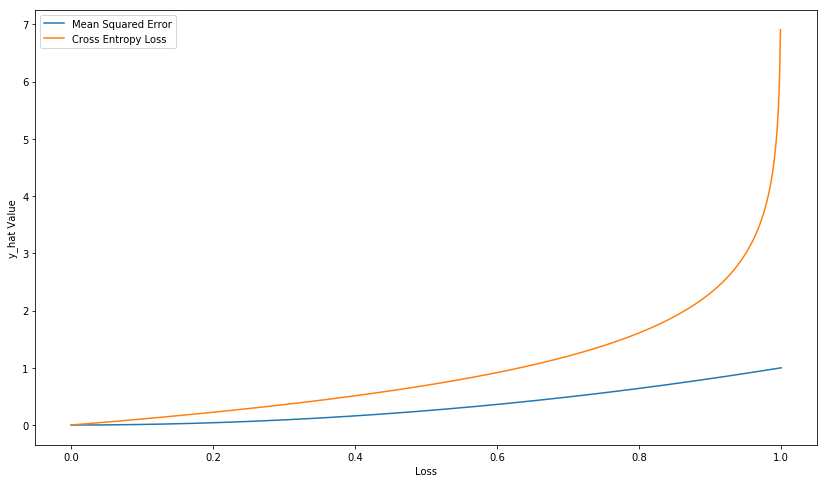

In [12]:
# cross entropy vs. squared error loss over y_hat interval [0,1] and target y = 0
NUM_DUMMY_POINTS = 1000
y_hat_in = np.linspace(0 , 1, NUM_DUMMY_POINTS)
y_in = np.full([NUM_DUMMY_POINTS], 0.)

# tensorflow placeholders
y_hat = tf.placeholder(tf.float32)
y = tf.placeholder(tf.float32)

# mean squared error loss
test_mse = tf.square(y_hat - y)

# cross entropy loss
test_cel = - y * tf.log(y_hat) - (1 - y) * tf.log(1 - y_hat)



sess.run(init)
result_mse, result_cel = sess.run([test_mse, test_cel], feed_dict={y_hat:y_hat_in, y:y_in})

plt.figure(figsize=(14, 8))
plt.plot(y_hat_in, result_mse, label='Mean Squared Error')
plt.plot(y_hat_in, result_cel, label='Cross Entropy Loss')
plt.legend()
plt.ylabel('y_hat Value')
plt.xlabel('Loss')
plt.savefig('1.1.3-explanation.png')